# CS 20 : TensorFlow for Deep Learning Research
## Lecture 07 : ConvNet in TensorFlow
### ConvNet mnist by low-level
- Creating the **data pipeline** with `tf.data`
- Creating the model as **Class** with `tf.nn`
- Training the model with **Drop out** technique by `tf.nn.dropout`

### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.12.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 28, 28, 1).astype(np.float32)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices].astype(np.int32)

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0).astype(np.int32)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 28, 28, 1) (55000,)
(5000, 28, 28, 1) (5000,)


### Define SimpleCNN class by low-level api

In [4]:
class SimpleCNN:
    def __init__(self, X, y, n_of_classes):
        
        self._X = X
        self._y = y
        self._keep_prob = tf.placeholder(dtype = tf.float32)
        
        conv1 = self._conv_relu(inputs = self._X, filters = 32, k_size = 5, stride = 1, padding = 'SAME',
                                scope_name = 'conv1')
        pool1 = self._max_pool(inputs = conv1, k_size = 2, stride = 2, padding = 'SAME',
                               scope_name = 'pool1')
        conv2 = self._conv_relu(inputs = pool1, filters = 64, k_size = 5, stride = 1, padding = 'SAME',
                                scope_name = 'conv2')
        pool2 = self._max_pool(inputs = conv2, k_size = 2, stride = 2, padding = 'SAME',
                               scope_name = 'pool2')
        flat_dim = pool2.get_shape().as_list()[1:]
        flattened = tf.reshape(tensor = pool2, shape = [-1,flat_dim[0] * flat_dim[1] * flat_dim[2]])

        pre_fc = self._fully_connected(inputs = flattened, out_dim = 1024, scope_name = 'fc1')
        fc = tf.nn.relu(pre_fc)
        dropped = tf.nn.dropout(x = fc, keep_prob = self._keep_prob)
        
        self._score = self._fully_connected(inputs = dropped, out_dim = n_of_classes, scope_name = 'score')
        self.ce_loss = self._loss(labels = self._y, logits = self._score, scope_name = 'ce_loss')
        
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input = self._score, axis = -1)
        
    def _conv_relu(self, inputs, filters, k_size, stride = 1, padding = 'SAME', scope_name = 'conv'):
        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE):
            in_channels = inputs.get_shape().as_list()[-1]
            filter_weights = tf.get_variable(name = 'weights', shape = [k_size, k_size, in_channels, filters],
                                             dtype = tf.float32, initializer = tf.truncated_normal_initializer())
            biases = tf.get_variable(name = 'biases', shape = [filters], dtype = tf.float32,
                                            initializer = tf.random_normal_initializer())
            conv = tf.nn.conv2d(input = inputs, filter = filter_weights,
                                strides = [1, stride, stride, 1], padding = padding)
            pre_activation = conv + biases
            activation = tf.nn.relu(pre_activation)
            return activation
        
    def _max_pool(self, inputs, k_size = 2, stride = 2, padding = 'SAME', scope_name = 'max_pool'):
        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE):
            pool = tf.nn.max_pool(value = inputs, ksize = [1, k_size, k_size, 1],
                                  strides = [1, stride, stride, 1], padding = padding)
            return pool
        
    def _fully_connected(self, inputs, out_dim, scope_name = 'fc'):
        with tf.variable_scope(scope_name) :
            in_dim = inputs.get_shape().as_list()[-1]
            weights = tf.get_variable(name = 'weights', shape = [in_dim, out_dim],
                                      dtype = tf.float32, initializer = tf.truncated_normal_initializer())
            biases = tf.get_variable(name = 'biases', shape = [out_dim], dtype = tf.float32,
                                     initializer = tf.constant_initializer())
            pre_activation = tf.matmul(inputs, weights) + biases
            return pre_activation
        
    def _loss(self, labels, logits, scope_name):
        with tf.variable_scope(scope_name):
            ce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits))
            return ce_loss
        
    def predict(self, sess, x_data, keep_prob = 1.):
        feed_prediction = {self._X : x_data, self._keep_prob : keep_prob}
        return sess.run(self._prediction, feed_dict = feed_prediction)

### Create a model of SimpleCNN

In [5]:
# hyper-parameter
lr = .003
epochs = 50
batch_size = 64
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

859


In [6]:
## create input pipeline with tf.data
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()
print(val_dataset)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>


In [7]:
## define Iterator
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(dtype = tf.string)
iterator = tf.data.Iterator.from_string_handle(string_handle = handle,
                                               output_types = tr_iterator.output_types,
                                               output_shapes = tr_iterator.output_shapes)

x_data, y_data = iterator.get_next()

In [8]:
## connecting data pipeline with model
cnn = SimpleCNN(X = x_data, y = y_data, n_of_classes = 10)

### Create training op and train model

In [9]:
## create training op
opt = tf.train.AdamOptimizer(learning_rate = lr)

# equal to 'var_list = None'
training_op = opt.minimize(loss = cnn.ce_loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0

    # for mini-batch training
    sess.run(tr_iterator.initializer)    
    try:
        while True:
            _, tr_loss = sess.run(fetches = [training_op, cnn.ce_loss],
                                               feed_dict = {handle : tr_handle, cnn._keep_prob : .5})
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass

    # for validation
    sess.run(val_iterator.initializer)
    try:
        while True:
            val_loss = sess.run(fetches = cnn.ce_loss, feed_dict = {handle : val_handle, cnn._keep_prob : 1.})
            avg_val_loss += val_loss
            val_step += 1
    
    except tf.errors.OutOfRangeError:
        pass

    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

epoch :   5, tr_loss : 29.171, val_loss : 14.128
epoch :  10, tr_loss : 5.974, val_loss : 3.577
epoch :  15, tr_loss : 1.275, val_loss : 1.100
epoch :  20, tr_loss : 1.169, val_loss : 0.655
epoch :  25, tr_loss : 0.990, val_loss : 0.522
epoch :  30, tr_loss : 0.960, val_loss : 0.513
epoch :  35, tr_loss : 0.718, val_loss : 0.310
epoch :  40, tr_loss : 0.624, val_loss : 0.337
epoch :  45, tr_loss : 0.636, val_loss : 0.437
epoch :  50, tr_loss : 0.504, val_loss : 0.357


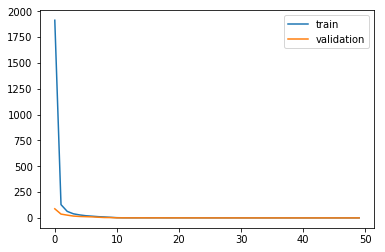

In [11]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [12]:
yhat = cnn.predict(sess = sess, x_data = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))

test acc: 91.30%
